In [1]:
from dotenv import load_dotenv

load_dotenv()

True

**Extract the data**

Extract the elements of the PDF that we will be able to use in the retrieval process. These elements can be Text, Images, Tables, etc.

Partition PDF tables, text and images

In [2]:
# import pytesseract
# import os
from unstructured.partition.pdf import partition_pdf

output_path = './data'
file_path = output_path + '/raw_papers/A survey on 3DGS.pdf'

# pytesseract.pytesseract.tesseract_cmd = r'C:/Users/nguye/AppData/Local/Programs/Tesseract-OCR/tesseract.exe'
# os.environ["UNSTRUCTURED_HI_RES_MODEL_NAME"] = "yolox"
chunks = partition_pdf(
    filename=file_path,
    infer_table_structure=True, # extract tables
    strategy="hi_res",          # mandatory to infer tables
    languages=["eng"],          # specify languages for OCR
    extract_image_block_types=["Image"], # extract images and tables
    extract_image_block_to_payload=True,
    chunking_strategy="by_title",
    max_characters=10000,
    combine_text_under_n_chars=2000,
    new_after_n_chars=6000
)

The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [3]:
chunks[9].metadata.orig_elements

In [4]:
elements = chunks[5].metadata.orig_elements
chunk_images = [el for el in elements if 'Image' in str(type(el))]

chunk_images[0].to_dict()

{'type': 'Image',
 'element_id': '82723330-eb90-4886-a67b-efe647e52136',
 'text': 'MLP |',
 'metadata': {'coordinates': {'points': ((np.float64(245.43591483333336),
     np.float64(246.5095174444444)),
    (np.float64(245.43591483333336), np.float64(392.1418874444444)),
    (np.float64(342.0062848333333), np.float64(392.1418874444444)),
    (np.float64(342.0062848333333), np.float64(246.5095174444444))),
   'system': 'PixelSpace',
   'layout_width': 1700,
   'layout_height': 2200},
  'last_modified': '2025-07-01T22:51:30',
  'filetype': 'PPM',
  'languages': ['eng'],
  'page_number': 4,
  'image_base64': '/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCACRAGEDASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0R

**Separate extracted elements into tables, text and images**

In [5]:
# Separate tables from texts
tables = []
text = []

for chunk in chunks:
    if "Table" in str(type(chunk)):
        tables.append(chunk)
    
    if "CompositeElement" in str(type(chunk)):
        text.append(chunk)

In [6]:
# Get the images from the CompositeElement objects
def get_images_base64(chunks):
    images_b64 = []
    for chunk in chunks:
        if "CompositeElement" in str(type(chunk)):
            chunk_els = chunk.metadata.orig_elements
            for el in chunk_els:
                if 'Image' in str(type(el)):
                    images_b64.append(el.metadata.image_base64)
    return images_b64

images = get_images_base64(chunks)

Check what the images look like

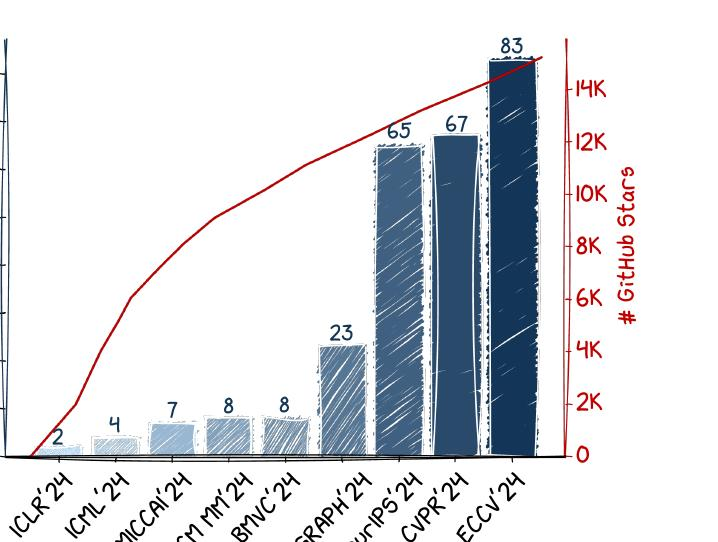

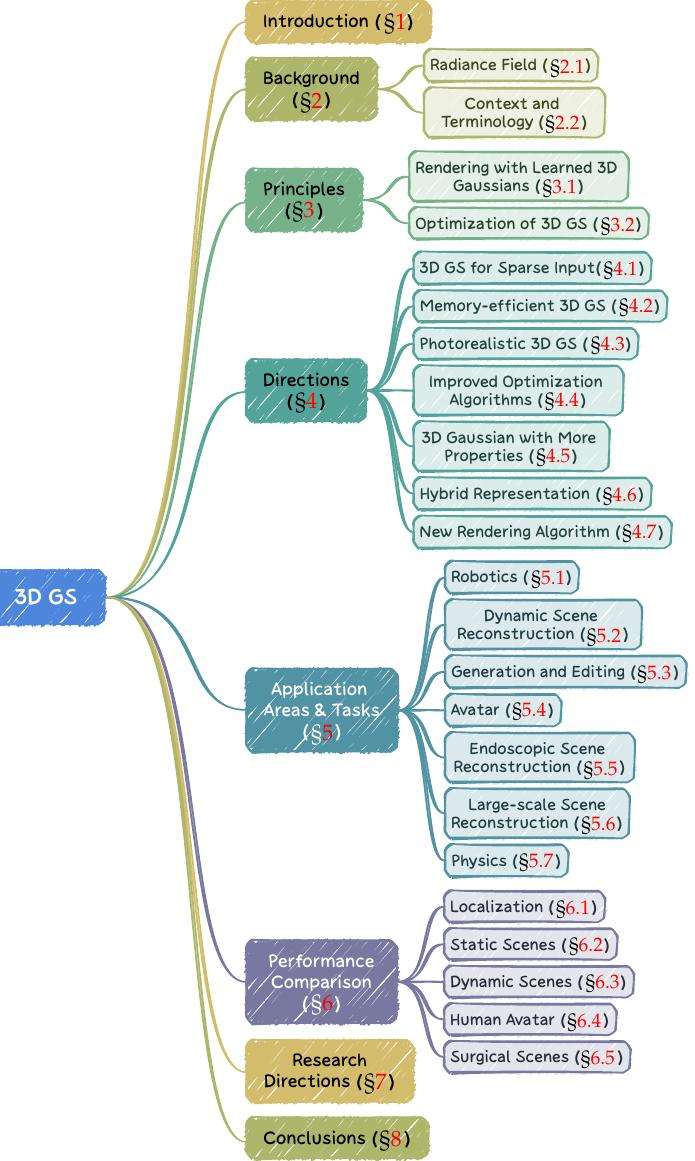

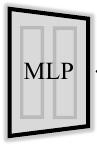

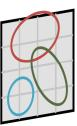

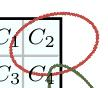

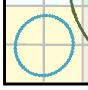

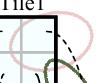

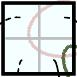

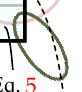

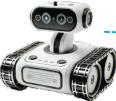

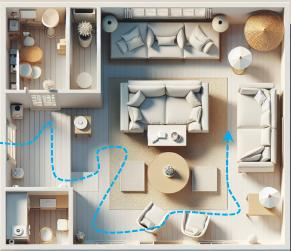

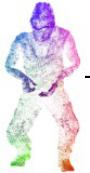

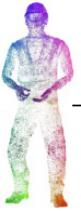

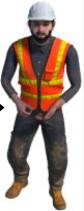

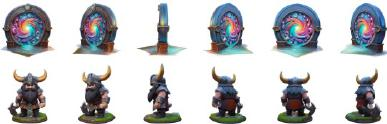

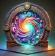

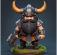

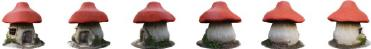

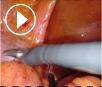

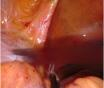

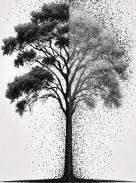

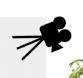

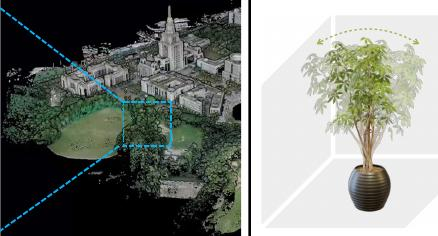

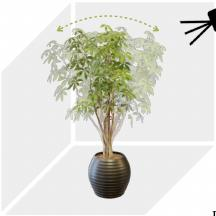

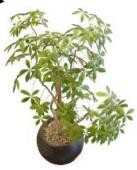

In [7]:
import base64
from IPython.display import Image, display

def display_base64_image(b64_string):
    image_data = base64.b64decode(b64_string)
    display(Image(data=image_data))

for i in range(len(images)):
    display_base64_image(images[i])

**Summarize the data**

Create a summary of each element extracted from the PDF. This summary will be vectorized and used in the retrieval process.

**Text and Table summarizes**

We do not need a multimodal modele to generate the summaries of the table and the text. I will use open source models available on Groq.

In [9]:
from langchain_groq import ChatGroq
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [10]:
# Prompt
prompt_text = """
You are an assistant tasked with summarizing tables and text.
Give a concise summary of the table or text.

Respond only with the summary, without any additional commentary.
Do not start your message by saying "The summary is" or similar phrases.
Just give the summary as it is.

Table or text chunk: {element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)

# Summary chain
model = ChatGroq(model="llama-3.1-8b-instant", temperature=0.5)
summary_chain = prompt | model | StrOutputParser()

In [21]:
# Summarize text
text_summaries = summary_chain.batch(text, {"max_concurrency": 2})

# Summarize tables
table_html = [table.metadata.text_as_html for table in tables]
table_summaries = summary_chain.batch(table_html, {"max_concurrency": 2})

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.1-8b-instant` in organization `org_01k8mxcbwrfkgr5byn5tv955ma` service tier `on_demand` on tokens per minute (TPM): Limit 6000, Used 5470, Requested 1307. Please try again in 7.77s. Need more tokens? Upgrade to Dev Tier today at https://console.groq.com/settings/billing', 'type': 'tokens', 'code': 'rate_limit_exceeded'}}